In [1]:
import os
import time

import pyro
import seaborn as sns
import torch

pyro.settings.set(module_local_params=True)

sns.set_style("white")

seed = 123
pyro.clear_param_store()
pyro.set_rng_seed(seed)

import seaborn as sns
import torch

from collab.foraging import locust as lc

smoke_test = "CI" in os.environ
end = 5 if smoke_test else 15
num_samples = 10 if smoke_test else 150
num_iterations = 10 if smoke_test else 1500
notebook_starts = time.time()

In [2]:
locds = lc.LocustDS(
    data_code="15EQ20191202",
    start=0,
    end=end,
)

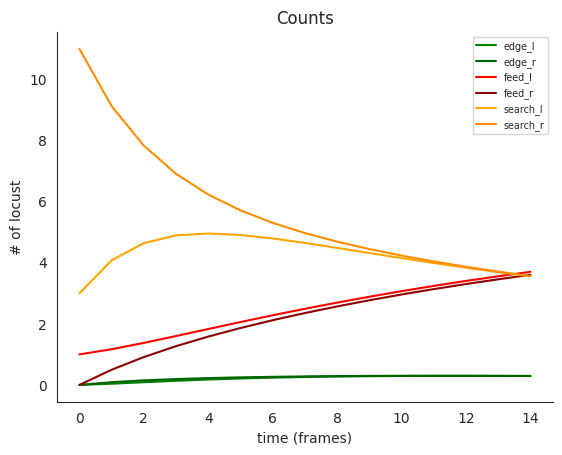

In [3]:
true_attraction = torch.tensor([0.01, 0.01, 0.01, 0.01, 0.01])
true_wander = torch.tensor([0.2, 0.1, 0.01, 0.05])


locds.simulate_trajectories(
    true_attraction=true_attraction,
    true_wander=true_wander,
)

locds.plot_simulated_trajectories()

In [4]:
locds.get_prior_samples(num_samples=num_samples)

In [5]:
locds.run_inference(
    "length", num_iterations=num_iterations, num_samples=num_samples, lr=0.001
)

Loading inference samples


In [6]:
locds.evaluate()
locds.rsquared

tensor(0.2575, dtype=torch.float64)

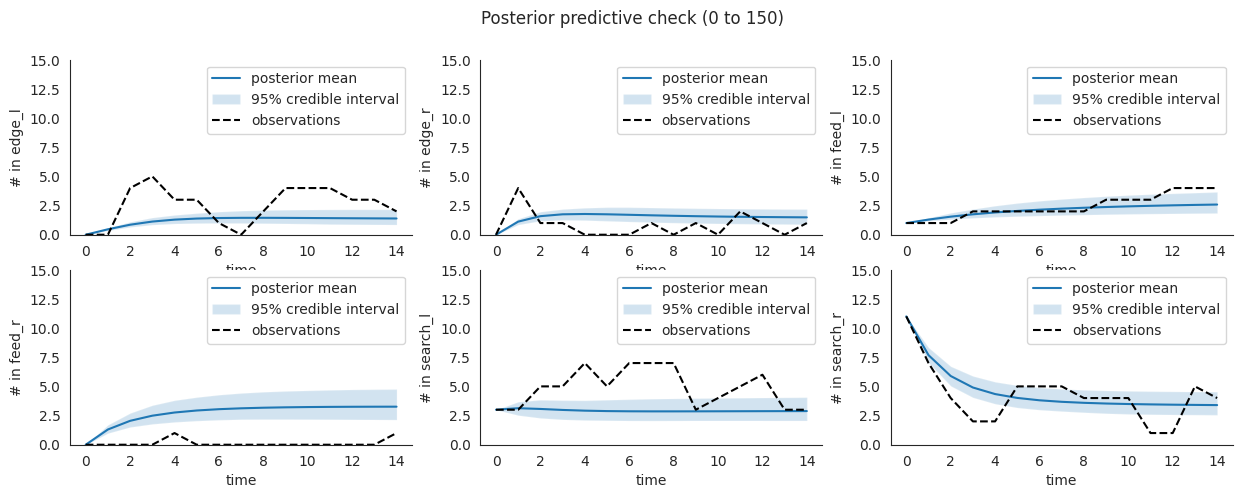

In [7]:
locds.posterior_check()

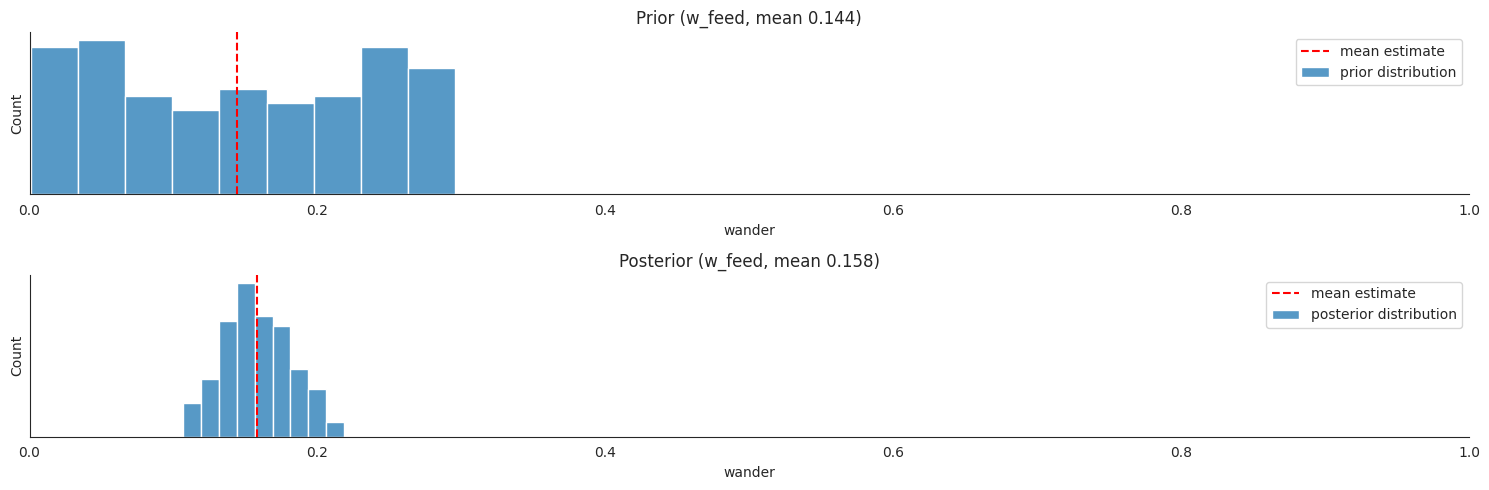

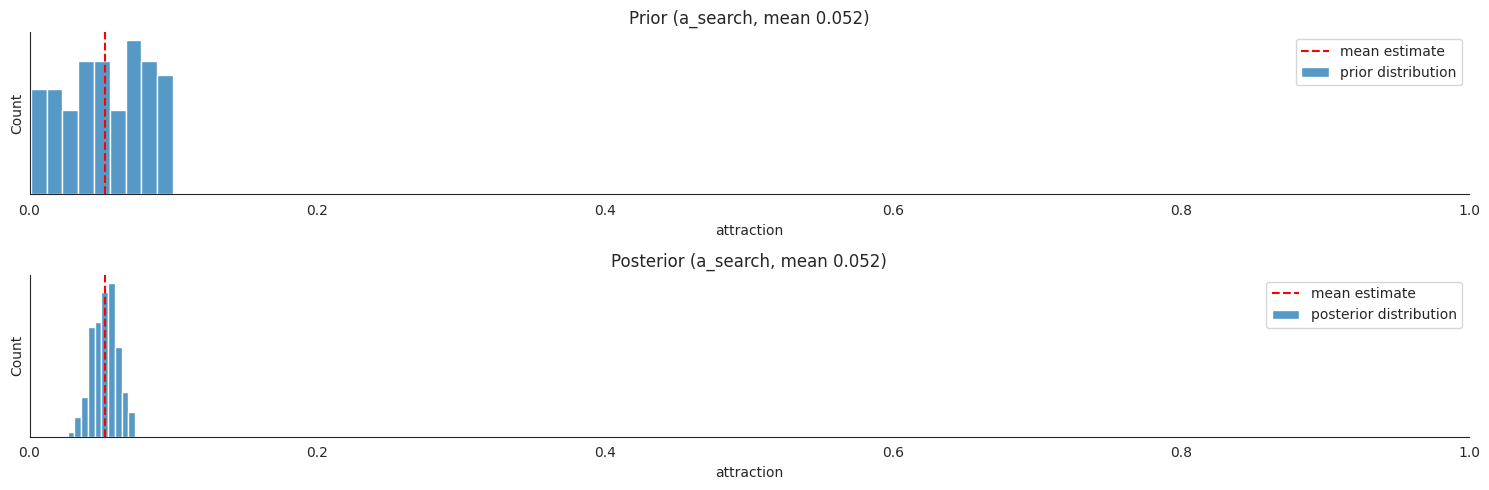

In [8]:
locds.plot_param_estimates(3, 3)

Loading validation samples


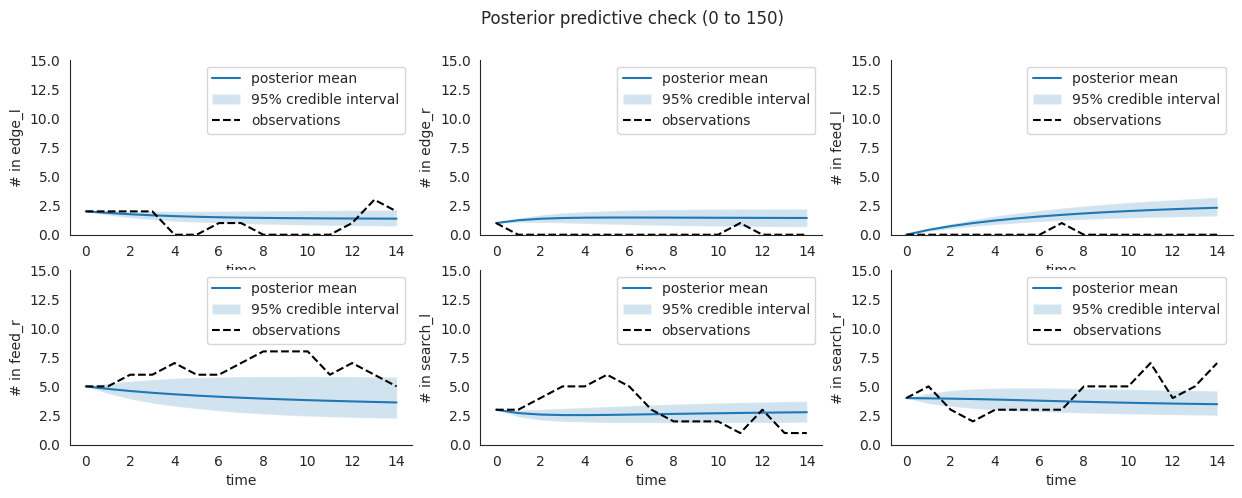

In [9]:
locds.validate(validation_data_code="15EQ20191205")
locds.posterior_check(samples=locds.v_samples, subset=locds.v_subset)

In [10]:
notebook_ends = time.time()
print(
    "notebook took",
    notebook_ends - notebook_starts,
    "seconds, that is ",
    (notebook_ends - notebook_starts) / 60,
    "minutes to run",
)

notebook took 3.8007631301879883 seconds, that is  0.0633460521697998 minutes to run
